In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import os



=== Latency summary (ms) ===
                           n   mean_ms    std_ms    min_ms    p50_ms    p90_ms    p95_ms    p99_ms    max_ms
preprocess_ms           18.0   247.552   657.614     8.662    22.571   607.032  1974.706  2125.009  2162.585
inference_ms            18.0  3145.400  1690.921  2071.517  2714.410  4442.752  7652.376  7789.515  7823.800
postprocess_ms          18.0     0.173     0.099     0.070     0.152     0.273     0.324     0.449     0.480
total_pipeline_ms       18.0  3393.125  2340.385  2080.255  2730.808  5110.480  9768.407  9781.505  9784.780
inf/events_ms           14.0   186.874   159.365    18.985   126.122   406.124   480.872   524.816   535.802
inference_per_event_ms  14.0   186.874   159.365    18.985   126.122   406.124   480.872   524.816   535.802

Jitter (std/mean) for total_pipeline_ms: 0.6897
IQR outlier bounds for total_pipeline_ms: [1819.07, 3515.39] ms

=== Outliers (IQR rule) ===
                 dt                 wav_file  total_pipeline_ms  

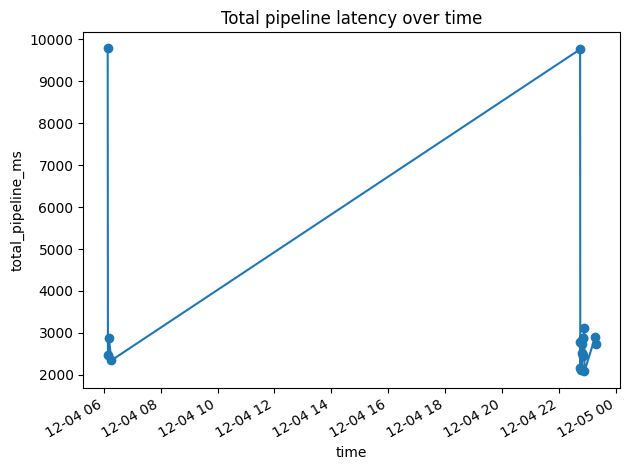

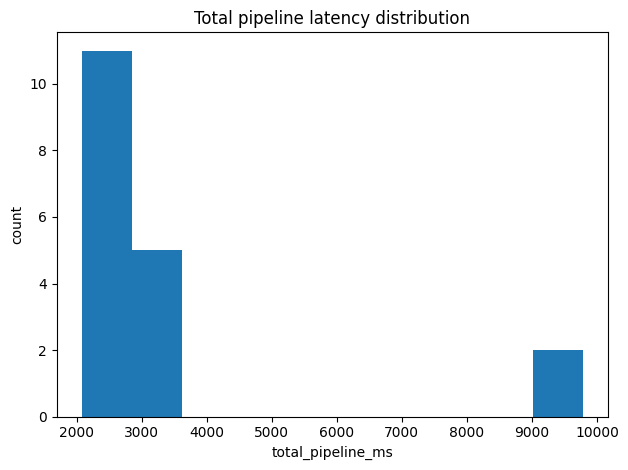

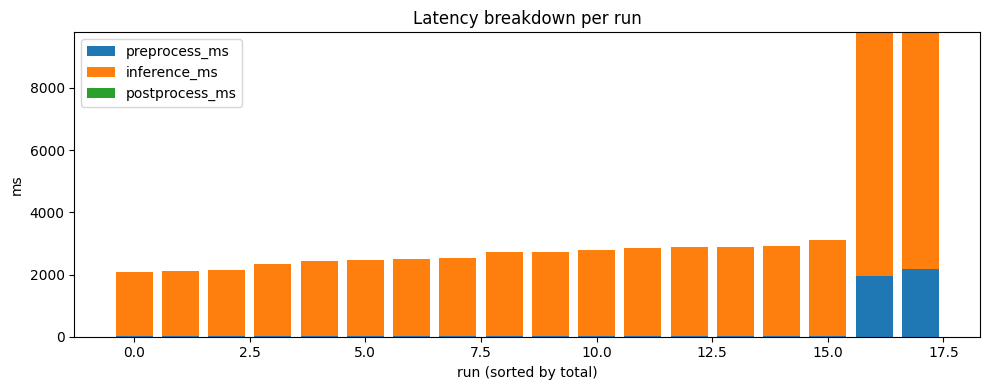

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- config ---
CSV_PATH = "latency_results.csv"          # or full path: r"/mnt/data/latency_results.csv"
OUT_PREFIX = "latency_eval"               # output files will start with this

# --- load + clean ---
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]  # fixes " events" -> "events" etc.

# coerce likely numeric columns (safe even if already numeric)
for c in ["timestamp","preprocess_ms","inference_ms","postprocess_ms","total_pipeline_ms","inf/events_ms","events"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# add a datetime for easy plotting (timestamps look like unix seconds)
if "timestamp" in df.columns:
    df["dt"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")

# compute end-to-end if not present (or compare against provided total)
parts = [c for c in ["preprocess_ms", "inference_ms", "postprocess_ms"] if c in df.columns]
if "total_pipeline_ms" not in df.columns and parts:
    df["total_pipeline_ms"] = df[parts].sum(axis=1)

# optional: recompute inference-per-event if missing/invalid and events>0
if "events" in df.columns and "inference_ms" in df.columns:
    df["inference_per_event_ms"] = np.where(df["events"] > 0, df["inference_ms"] / df["events"], np.nan)

# --- summary stats helper ---
def latency_summary(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return pd.Series(dtype=float)
    return pd.Series({
        "n": s.size,
        "mean_ms": s.mean(),
        "std_ms": s.std(ddof=1) if s.size > 1 else 0.0,
        "min_ms": s.min(),
        "p50_ms": s.quantile(0.50),
        "p90_ms": s.quantile(0.90),
        "p95_ms": s.quantile(0.95),
        "p99_ms": s.quantile(0.99),
        "max_ms": s.max(),
    })

metrics = {}
for col in ["preprocess_ms","inference_ms","postprocess_ms","total_pipeline_ms","inf/events_ms","inference_per_event_ms"]:
    if col in df.columns:
        metrics[col] = latency_summary(df[col])

summary = pd.DataFrame(metrics).T
print("\n=== Latency summary (ms) ===")
print(summary.round(3).to_string())

# --- jitter (std/mean) + outliers (IQR rule) on total pipeline ---
if "total_pipeline_ms" in df.columns:
    s = df["total_pipeline_ms"].dropna()
    jitter = (s.std(ddof=1) / s.mean()) if s.size > 1 and s.mean() != 0 else np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = df.loc[(df["total_pipeline_ms"] < lo) | (df["total_pipeline_ms"] > hi),
                      ["dt","wav_file","total_pipeline_ms","preprocess_ms","inference_ms","postprocess_ms","events"]
                     ].sort_values("total_pipeline_ms", ascending=False)

    print(f"\nJitter (std/mean) for total_pipeline_ms: {jitter:.4f}")
    print(f"IQR outlier bounds for total_pipeline_ms: [{lo:.2f}, {hi:.2f}] ms")
    if len(outliers):
        print("\n=== Outliers (IQR rule) ===")
        print(outliers.to_string(index=False))
        outliers.to_csv(f"{OUT_PREFIX}_outliers.csv", index=False)

# --- plots ---
# 1) time series of total pipeline latency
if "dt" in df.columns and "total_pipeline_ms" in df.columns:
    plt.figure()
    plt.plot(df["dt"], df["total_pipeline_ms"], marker="o")
    plt.xlabel("time")
    plt.ylabel("total_pipeline_ms")
    plt.title("Total pipeline latency over time")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(f"{OUT_PREFIX}_timeseries_total.png", dpi=200)

# 2) histogram of total pipeline latency
if "total_pipeline_ms" in df.columns:
    plt.figure()
    plt.hist(df["total_pipeline_ms"].dropna(), bins=10)
    plt.xlabel("total_pipeline_ms")
    plt.ylabel("count")
    plt.title("Total pipeline latency distribution")
    plt.tight_layout()
    plt.savefig(f"{OUT_PREFIX}_hist_total.png", dpi=200)

# 3) stacked breakdown per run (pre/infer/post) sorted by total
have_breakdown = all(c in df.columns for c in ["preprocess_ms","inference_ms","postprocess_ms","total_pipeline_ms"])
if have_breakdown:
    d = df.sort_values("total_pipeline_ms").reset_index(drop=True)
    x = np.arange(len(d))
    plt.figure(figsize=(10, 4))
    plt.bar(x, d["preprocess_ms"], label="preprocess_ms")
    plt.bar(x, d["inference_ms"], bottom=d["preprocess_ms"], label="inference_ms")
    plt.bar(x, d["postprocess_ms"], bottom=d["preprocess_ms"] + d["inference_ms"], label="postprocess_ms")
    plt.xlabel("run (sorted by total)")
    plt.ylabel("ms")
    plt.title("Latency breakdown per run")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{OUT_PREFIX}_breakdown_stacked.png", dpi=200)

# save cleaned data + summary
df.to_csv(f"{OUT_PREFIX}_cleaned.csv", index=False)
summary.round(6).to_csv(f"{OUT_PREFIX}_summary.csv")

print(f"\nSaved: {OUT_PREFIX}_cleaned.csv, {OUT_PREFIX}_summary.csv, and PNG plots with prefix {OUT_PREFIX}_*.png")



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# -------- CONFIG --------
CSV_PATH = "latency_results.csv"     # adjust path if needed
OUT_DIR = Path("latency_hists")      # actual directory now
BINS = 10

def safe_filename(name: str) -> str:
    # replace anything problematic (like / \ : * ? " < > | spaces) with underscore
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(name)).strip("_")

# ------------------------
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

OUT_DIR.mkdir(parents=True, exist_ok=True)

# numeric columns only
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

pct_rows = []

for col in num_cols:
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        continue

    p50 = s.quantile(0.50)
    p95 = s.quantile(0.95)

    pct_rows.append({
        "metric": col,
        "median_p50": p50,
        "p95": p95,
        "min": s.min(),
        "max": s.max(),
        "mean": s.mean(),
        "n": int(s.size),
    })

    # ---- histogram ----
    plt.figure()
    plt.hist(s, bins=BINS)
    plt.axvline(p50, linestyle="--", linewidth=2, label=f"P50 = {p50:.2f}")
    plt.axvline(p95, linestyle=":", linewidth=2, label=f"P95 = {p95:.2f}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.title(f"Histogram: {col}")
    plt.legend()
    plt.tight_layout()

    out_png = OUT_DIR / f"{safe_filename(col)}.png"
    plt.savefig(out_png, dpi=200)
    plt.close()

summary = pd.DataFrame(pct_rows).set_index("metric").round(3)

print("\n=== Latency Percentiles (ms) ===")
print(summary.to_string())

summary.to_csv(OUT_DIR / "percentiles.csv")
print(f"\nSaved histograms to: {OUT_DIR.resolve()}")



=== Latency Percentiles (ms) ===
                     median_p50           p95           min           max          mean   n
metric                                                                                     
timestamp          1.764889e+09  1.764890e+09  1.764829e+09  1.764890e+09  1.764875e+09  18
preprocess_ms      2.257100e+01  1.974706e+03  8.662000e+00  2.162585e+03  2.475520e+02  18
inference_ms       2.714410e+03  7.652376e+03  2.071517e+03  7.823800e+03  3.145400e+03  18
inf/events_ms      1.261220e+02  4.808720e+02  1.898500e+01  5.358020e+02  1.868740e+02  14
postprocess_ms     1.520000e-01  3.240000e-01  7.000000e-02  4.800000e-01  1.730000e-01  18
total_pipeline_ms  2.730808e+03  9.768407e+03  2.080255e+03  9.784780e+03  3.393125e+03  18
events             1.850000e+01  7.120000e+01  0.000000e+00  1.290000e+02  2.550000e+01  18

Saved histograms to: C:\Users\evand\OneDrive\Desktop\CSE5312\Final Project\.venv\latency_hists


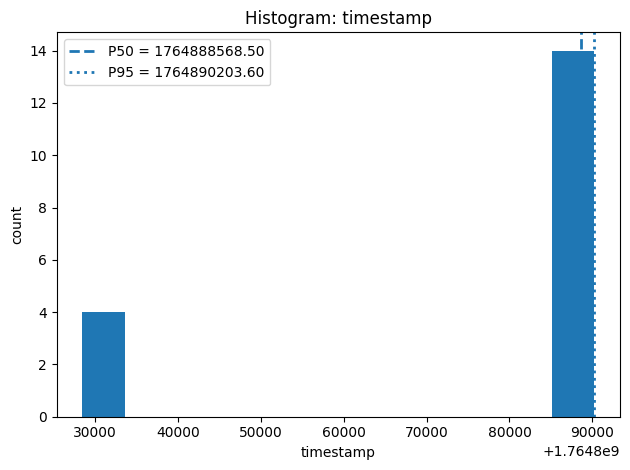

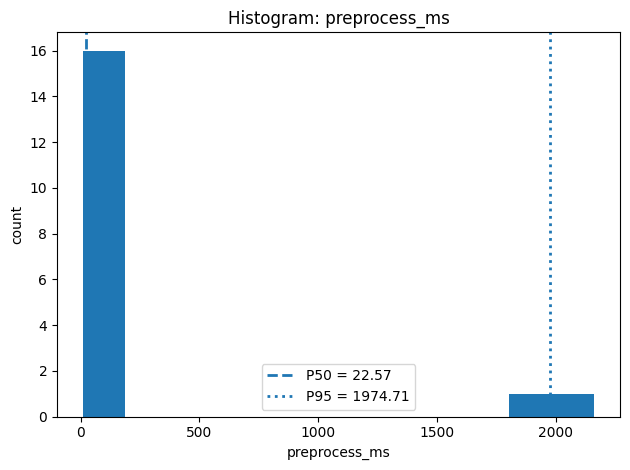

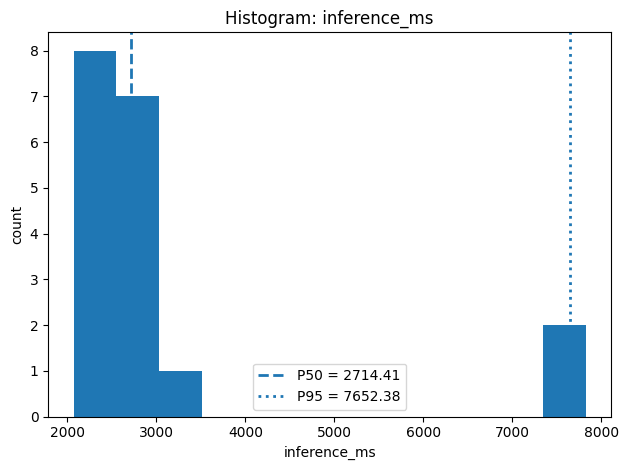

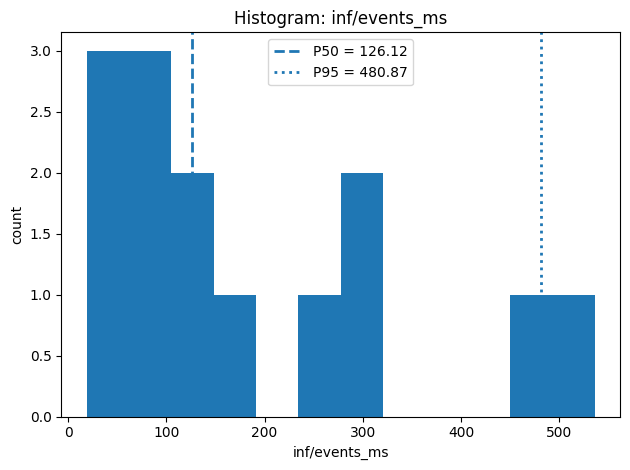

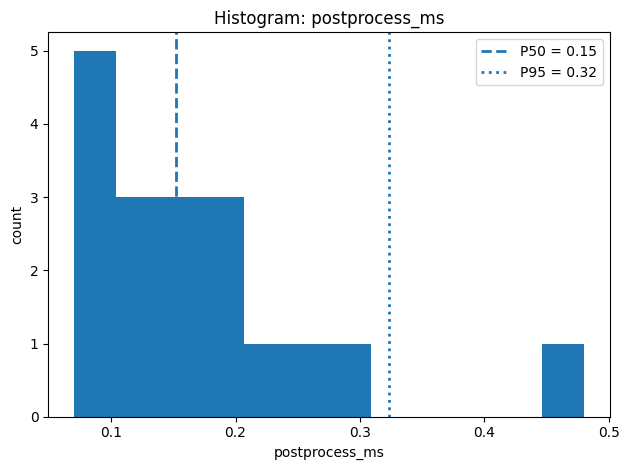

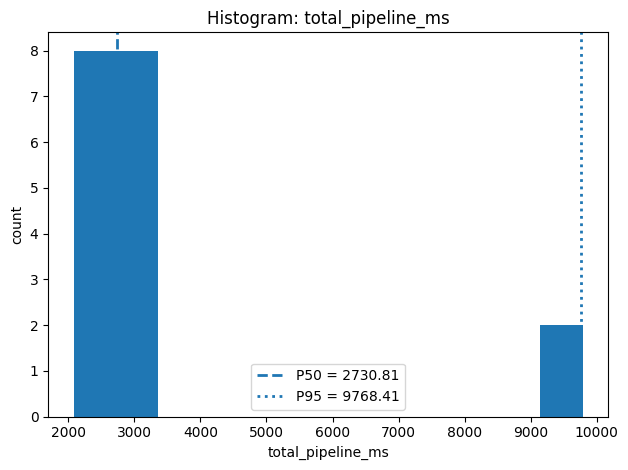

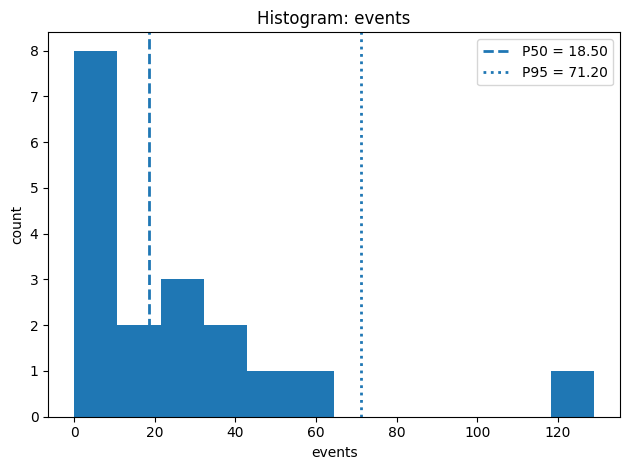


=== Median (P50) and P95 by metric ===
                    n    median_p50           p95
metric                                           
events             18  1.850000e+01  7.120000e+01
inf/events_ms      14  1.261220e+02  4.808720e+02
inference_ms       18  2.714410e+03  7.652376e+03
postprocess_ms     18  1.520000e-01  3.240000e-01
preprocess_ms      18  2.257100e+01  1.974706e+03
timestamp          18  1.764889e+09  1.764890e+09
total_pipeline_ms  18  2.730808e+03  9.768407e+03

Saved percentiles to: C:\Users\evand\OneDrive\Desktop\CSE5312\Final Project\.venv\latency_outputs\percentiles_summary.csv
Saved histograms to: C:\Users\evand\OneDrive\Desktop\CSE5312\Final Project\.venv\latency_outputs\histograms


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# -------- CONFIG --------
CSV_PATH = "latency_results.csv"   # change if needed
OUT_DIR = Path("latency_outputs")
HIST_DIR = OUT_DIR / "histograms"
BINS = 12

def safe_filename(name: str) -> str:
    # makes column names like "inf/events_ms" safe for Windows/macOS/Linux filenames
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(name)).strip("_")

# ------------------------
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

OUT_DIR.mkdir(parents=True, exist_ok=True)
HIST_DIR.mkdir(parents=True, exist_ok=True)

# Pick numeric columns; also attempt to coerce "ms-like" columns that might be strings
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
maybe_latency_cols = [c for c in df.columns if ("ms" in c.lower() or "lat" in c.lower()) and c not in num_cols]

for c in maybe_latency_cols:
    coerced = pd.to_numeric(df[c], errors="coerce")
    if coerced.notna().any():
        df[c] = coerced
        num_cols.append(c)

# de-dupe while preserving order
seen = set()
num_cols = [c for c in num_cols if not (c in seen or seen.add(c))]

rows = []

for col in num_cols:
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        continue

    p50 = float(s.quantile(0.50))
    p95 = float(s.quantile(0.95))

    rows.append({
        "metric": col,
        "n": int(s.size),
        "median_p50": p50,
        "p95": p95,
        "mean": float(s.mean()),
        "min": float(s.min()),
        "max": float(s.max()),
    })

    # ---- histogram (with P50 + P95 lines) ----
    plt.figure()
    plt.hist(s, bins=BINS)
    plt.axvline(p50, linestyle="--", linewidth=2, label=f"P50 = {p50:.2f}")
    plt.axvline(p95, linestyle=":", linewidth=2, label=f"P95 = {p95:.2f}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.title(f"Histogram: {col}")
    plt.legend()
    plt.tight_layout()

    plt.savefig(HIST_DIR / f"{safe_filename(col)}.png", dpi=200)
    plt.show()
    plt.close()

summary = pd.DataFrame(rows).set_index("metric").sort_index().round(3)

print("\n=== Median (P50) and P95 by metric ===")
print(summary[["n", "median_p50", "p95"]].to_string())

summary.to_csv(OUT_DIR / "percentiles_summary.csv")
print(f"\nSaved percentiles to: {(OUT_DIR / 'percentiles_summary.csv').resolve()}")
print(f"Saved histograms to: {HIST_DIR.resolve()}")
